In [1]:
import numpy as np
import pandas as pd
import os
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as stats

np.random.seed(97)

In [2]:
m = ["A", "C", "G", "T"]
def id2seq(ids):
    return "".join([m[i] for i in ids])

In [3]:
expression_percentile_thres = 90
ensemble_predictions_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/ensemble_predictions/"

In [4]:
os.listdir(ensemble_predictions_dir)

['filtered_ensemble_1_predictions.parquet',
 'dataset_seqs_eval_2.pkl',
 'filtered_coms_sequences_ensemble_2_6mer_counts_pairwise_euclidean_distances.npy',
 'den_seqs_eval_4.pkl',
 'dataset_seqs_eval_3.pkl',
 'all_ensemble_2_predictions.parquet',
 'sequences_from_batch_1_expression_spectrum_eval_4.pkl',
 'filtered_coms_sequences_ensemble_1_6mer_counts.npy',
 'filtered_coms_sequences_ensemble_2_6mer_counts.npy',
 'all_ensemble_predictions.parquet',
 'filtered_ensemble_2_predictions.parquet',
 'filtered_dens_sequences_ensemble_1.parquet',
 'dataset_seqs_eval.pkl',
 'filtered_ensemble_3_predictions.parquet',
 'filtered_dens_sequences_ensemble_3.parquet',
 'all_ensemble_1_predictions.parquet',
 'coms_seqs_eval_3.pkl',
 'sequences_from_batch_1_expression_spectrum_eval_3.pkl',
 'filtered_coms_sequences_ensemble_2.parquet',
 'all_ensemble_3_predictions.parquet',
 'dataset_seqs_eval_4.pkl',
 'coms_seqs_eval_2.pkl',
 'filtered_dens_sequences_ensemble_2_6mer_counts.npy',
 'coms_seqs_eval_4.pkl',

In [5]:
dataset_sequences = pickle.load(open(os.path.join(ensemble_predictions_dir, "dataset_seqs_eval_4.pkl"), "rb"))
sequences_from_batch_1_expression_spectrum = pickle.load(open(os.path.join(ensemble_predictions_dir, "sequences_from_batch_1_expression_spectrum_eval_4.pkl"), "rb"))
sequences_generated_using_DE_motifs = pickle.load(open(os.path.join(ensemble_predictions_dir, "sequences_generated_using_DE_motifs_eval_4.pkl"), "rb"))
coms_sequences = pickle.load(open(os.path.join(ensemble_predictions_dir, "coms_seqs_eval_4.pkl"), "rb"))
dens_sequences = pickle.load(open(os.path.join(ensemble_predictions_dir, "den_seqs_eval_4.pkl"), "rb"))

In [6]:
# process COMs sequences
coms_df = {}
coms_df["design_method"] = []
coms_df["designed_for"] = []
coms_df["original_sequence"] = []
coms_df["sequence"] = []
coms_df["provenance"] = []
coms_df["coms_alpha"] = []
coms_df["diversity_loss_coef"] = []
coms_df["entropy_loss_coef"] = []
coms_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    coms_df[cell + "_ensemble_mean"] = []
    coms_df[cell + "_ensemble_std"] = []
    coms_df[cell + "_all_ensemble_preds"] = []
    coms_df[cell + "_design_model"] = []
    coms_df[cell + "_measured"] = []

ori_sequences = [id2seq(i) for i in coms_sequences["original_seq"]]

for cell in ["jurkat", "k562", "thp1"]:
    print(cell)
    sequences = [id2seq(i) for i in coms_sequences[f"{cell}_optimized_seq"]]
    
    corrected_cell_name = cell.upper()
    if cell == "jurkat":
        corrected_cell_name = "Jurkat"
    
    coms_df["designed_for"] += [corrected_cell_name for i in range(len(sequences))]
    coms_df["original_sequence"] += ori_sequences.copy()
    coms_df["sequence"] += ["".join(i) for i in sequences]
    coms_df["coms_alpha"] += list(coms_sequences["coms_loss_weight"])
    coms_df["provenance"] += [None for i in sequences]
    coms_df["diversity_loss_coef"] += [None for i in sequences]
    coms_df["entropy_loss_coef"] += [None for i in sequences]
    coms_df["base_entropy_loss_coef"] += [None for i in sequences]
    coms_df["design_method"] += ["COMs" for i in sequences]
    
    for cell2 in ["Jurkat", "K562", "THP1"]:
        coms_df[cell2 + "_ensemble_mean"] += list(coms_sequences[f"ensemble_{cell}_optimized_seq_{cell2.lower()}_pred"].mean(axis=0))
        coms_df[cell2 + "_ensemble_std"] += list(coms_sequences[f"ensemble_{cell}_optimized_seq_{cell2.lower()}_pred"].std(axis=0))
        coms_df[cell2 + "_all_ensemble_preds"] += [coms_sequences[f"ensemble_{cell}_optimized_seq_{cell2.lower()}_pred"]]
        coms_df[cell2 + "_design_model"] += list(coms_sequences[f"{cell}_opt_seq_{cell2.lower()}_pred"])
        coms_df[cell2 + "_measured"] += [None for i in sequences]

cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    coms_df[cell2 + "_all_ensemble_preds"] = np.hstack(coms_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = coms_df[cell2 + "_all_ensemble_preds"].copy()
    coms_df.pop(cell2 + "_all_ensemble_preds")

coms_df = pd.DataFrame(coms_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    coms_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(coms_df.shape[0])]
    
coms_df

jurkat
k562
thp1


design_method designed_for  \
0               COMs       Jurkat   
1               COMs       Jurkat   
2               COMs       Jurkat   
3               COMs       Jurkat   
4               COMs       Jurkat   
...              ...          ...   
306427          COMs         THP1   
306428          COMs         THP1   
306429          COMs         THP1   
306430          COMs         THP1   
306431          COMs         THP1   

                                        original_sequence  \
0       GTCTCTGGGCCGGAAGCCCCCTCTCCTCCCCCGCCGCAGCCCCCTC...   
1       ACCCGTGGGGAGGCGGTGAACTCCTCCGCAGGGGCCGATGCCCGGG...   
2       CGCTACCTCACTCACGGGCGAGAACTAAGCACCTACTGTGGACCCG...   
3       AACCTGGGACAACAGCAAAAAAAAAAAAAAAAAAAAAAAGGCCCCA...   
4       ACCCGGTGCCGGAGGCCGTGGGCGGCGACATGCAGCAGCTGAACCA...   
...                                                   ...   
306427  TACCTTATTCTTTAATGATTGCTTGTCACCATACGGATGAATCAGA...   
306428  CCAACACCCTACCTTTCTCTCTCTGGACCCACTTCCTCTTGCTGCC...   
306429  TGGTTTTTGCAGTCACACAGCTTTCCGAGACCCTCGTCCAGAGCAG...   
306430  GAAGGGCAGACAGCTGCCAGATACTTGCACCCCATTCCCTGGGGCC...   
306431  GAAGGGGTGGGGAGGGGAGAGAGTCCCTTTCAGTGCCCAAGCCTGT...   

                                                 sequence provenance  \
0       TCGAATAGTCCTATAAGCTCGTAAACTCCTACGCCACTATTCAGTA...       None   
1       TCAGGTGGGGGGGGGGCTTCGCGAGGCGCGCTGTCGTAAAATCGGC...       None   
2       CGTGATGTCATTCCGTGGGGAATCATTATGTATCAATAGGTATGCC...       None   
3       ATGGTGAGAATTCATTAGTTAGTAAATAATGAGGGCGGGGGCGTGA...       None   
4       AATGGCACGCGTAAACGGCATGTAAAGCCATAGAGCAGGTAAGGCG...       None   
...                                                   ...        ...   
306427  ATCCACGTTCAGGATTGATTCCACGTCACTTCCGTATTGAAAAGCA...       None   
306428  GCAGCTCACTTCCGTCATCCTTCTTCGGCTACTTCCGCAGAAGTCC...       None   
306429  AGGGCTGTTGAGCAAAGAGGATAGCCGGGTCTCTGGTAGGCAGTAT...       None   
306430  TCTGGTCTGGCAGCTGGTAGCAATTTGAGCGGCTTTCTCTTTGCCT...       None   
306431  CCCAAGGAAAAAAAAAAGCCAACTCCTGCGCAGGTCCTTGTCCTGT...       None   

        coms_alpha diversity_loss_coef entropy_loss_coef  \
0             0.00                None              None   
1             0.00                None              None   
2             0.00                None              None   
3             0.00                None              None   
4             0.00                None              None   
...            ...                 ...               ...   
306427        0.03                None              None   
306428        0.03                None              None   
306429        0.03                None              None   
306430        0.03                None              None   
306431        0.03                None              None   

       base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_ensemble_std  \
0                        None              1.424300  ...           0.307729   
1                        None              1.804220  ...           0.320410   
2                        None              2.288362  ...           0.292209   
3                        None              0.813155  ...           0.179015   
4                        None              1.324752  ...           0.232928   
...                       ...                   ...  ...                ...   
306427                   None             -0.252594  ...           0.149066   
306428                   None              0.291112  ...           0.242282   
306429                   None             -0.364002  ...           0.154262   
306430                   None             -0.509244  ...           0.124745   
306431                   None             -0.563969  ...           0.108755   

        K562_design_model K562_measured  THP1_ensemble_mean  \
0                0.804079          None            0.334840   
1                1.947420          None            0.524022   
2                1.120590          None            0.833220   
3                0.617886          None   

In [7]:
# process DENs sequences
dens_df = {}
dens_df["design_method"] = []
dens_df["designed_for"] = []
dens_df["original_sequence"] = []
dens_df["sequence"] = []
dens_df["coms_alpha"] = []
dens_df["provenance"] = []
dens_df["diversity_loss_coef"] = []
dens_df["entropy_loss_coef"] = []
dens_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    dens_df[cell + "_ensemble_mean"] = []
    dens_df[cell + "_ensemble_std"] = []
    dens_df[cell + "_all_ensemble_preds"] = []
    dens_df[cell + "_design_model"] = []
    dens_df[cell + "_measured"] = []
    
dens_df["designed_for"] += list(dens_sequences["designed_for"])
dens_df["design_method"] += ["DENs" for i in dens_sequences["sequence"]]
dens_df["original_sequence"] += [None for i in dens_sequences["sequence"]]

dens_df["sequence"] += [id2seq(i) for i in dens_sequences["sequence"]]

dens_df["provenance"] += [None for i in dens_sequences["sequence"]]
dens_df["coms_alpha"] += [float(i.split("_")[1]) for i in dens_sequences["design_model"]]
dens_df["diversity_loss_coef"] += list(dens_sequences["diversity_loss_coef"])
dens_df["entropy_loss_coef"] += list(dens_sequences["entropy_loss_coef"])
dens_df["base_entropy_loss_coef"] += list(dens_sequences["base_entropy_loss_coef"])

for cell2 in ["Jurkat", "K562", "THP1"]:
    dens_df[cell2 + "_ensemble_mean"] += list(dens_sequences[f"ensemble_sequence_{cell2.lower()}_pred"].mean(axis=0))
    dens_df[cell2 + "_ensemble_std"] += list(dens_sequences[f"ensemble_sequence_{cell2.lower()}_pred"].std(axis=0))
    dens_df[cell2 + "_all_ensemble_preds"] += [dens_sequences[f"ensemble_sequence_{cell2.lower()}_pred"]]
    dens_df[cell2 + "_design_model"] += list(dens_sequences[f"{cell2}"])
    dens_df[cell2 + "_measured"] += [None for i in dens_sequences["designed_for"]]
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    dens_df[cell2 + "_all_ensemble_preds"] = np.hstack(dens_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = dens_df[cell2 + "_all_ensemble_preds"].copy()
    dens_df.pop(cell2 + "_all_ensemble_preds")

dens_df = pd.DataFrame(dens_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    dens_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(dens_df.shape[0])]
    
dens_df

design_method designed_for original_sequence  \
0               DENs         THP1              None   
1               DENs         THP1              None   
2               DENs         THP1              None   
3               DENs         THP1              None   
4               DENs         THP1              None   
...              ...          ...               ...   
117498          DENs         K562              None   
117499          DENs         K562              None   
117500          DENs         K562              None   
117501          DENs         K562              None   
117502          DENs         K562              None   

                                                 sequence  coms_alpha  \
0       AACAAATTTTAATATACTACAGCTTCGGCCTTGCTTTTTTTTTTTT...      0.0003   
1       AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...      0.0003   
2       AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...      0.0003   
3       AACAAATTTTAATATACTACAGCTTCGGCCTTGCTTTTTTTTTTTT...      0.0003   
4       AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...      0.0003   
...                                                   ...         ...   
117498  ACAAAAAACCAAAAAAGACCCCCAAAAAGCCCGCCCAACAAAAACG...      0.0000   
117499  AAACAACAAACACCAACACCAAAACCAAACCCCACCAAAAAAAAAA...      0.0000   
117500  AAAAAACAGCCCCAAAAACAAACACAAAAAAAAAACAACCCCGAAA...      0.0000   
117501  CACCCCCACACCCAAACCGAAACCACCACCCAAAAACCCCCCACAA...      0.0000   
117502  AAAAACCAGCCCCCCCCGGAAAAAAAAAAGAACCAGCAAAAACGAC...      0.0000   

       provenance  diversity_loss_coef  entropy_loss_coef  \
0            None                  1.0                1.0   
1            None                  1.0                1.0   
2            None                  1.0                1.0   
3            None                  1.0                1.0   
4            None                  1.0                1.0   
...           ...                  ...                ...   
117498       None                 10.0                1.0   
117499       None                 10.0                1.0   
117500       None                 10.0                1.0   
117501       None                 10.0                1.0   
117502       None                 10.0                1.0   

        base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_ensemble_std  \
0                          5.0              0.011464  ...           0.212556   
1                          5.0              0.037286  ...           0.218339   
2                          5.0              0.050075  ...           0.236840   
3                          5.0              0.127548  ...           0.258698   
4                          5.0              0.008353  ...           0.189107   
...                        ...                   ...  ...                ...   
117498                    10.0              0.373594  ...           0.370481   
117499                    10.0              0.305804  ...           0.375615   
117500                    10.0              0.414195  ...           0.386215   
117501                    10.0              0.432594  ...           0.419344   
117502                    10.0              0.340482  ...           0.382629   

        K562_design_model K562_measured  THP1_ensemble_mean  \
0                0.161597          None            0.302054   
1                0.177417          None            0.310958   
2                0.298792          None            0.374554   
3                0.211093          None            0.388589   
4                0.064643          None            0.261480   
...                   ...           ...                 ...   
117498           2.265131          None            0.079880   
117499           2.271510          None            0.103152   
117500           2.358301          None            0.153508   
117501           2.284508          None            0.144993   
117502           2.256965          None            0.119847   

        THP1_ensem

In [8]:
# process original dataset sequences
dataset_df = {}
dataset_df["design_method"] = []
dataset_df["designed_for"] = []
dataset_df["original_sequence"] = []
dataset_df["sequence"] = []
dataset_df["coms_alpha"] = []
dataset_df["provenance"] = []
dataset_df["diversity_loss_coef"] = []
dataset_df["entropy_loss_coef"] = []
dataset_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    dataset_df[cell + "_ensemble_mean"] = []
    dataset_df[cell + "_ensemble_std"] = []
    dataset_df[cell + "_all_ensemble_preds"] = []
    dataset_df[cell + "_design_model"] = []
    dataset_df[cell + "_measured"] = []

dataset_df["designed_for"] += [None for i in dataset_sequences["sequences"]]
dataset_df["design_method"] += ["Dataset" for i in dataset_sequences["sequences"]]
dataset_df["original_sequence"] += [None for i in dataset_sequences["sequences"]]

dataset_df["sequence"] += [id2seq(i) for i in dataset_sequences["sequences"]]

dataset_df["provenance"] += [None for i in dataset_sequences["sequences"]]
dataset_df["coms_alpha"] += [None for i in dataset_sequences["sequences"]]
dataset_df["diversity_loss_coef"] += [None for i in dataset_sequences["sequences"]]
dataset_df["entropy_loss_coef"] += [None for i in dataset_sequences["sequences"]]
dataset_df["base_entropy_loss_coef"] += [None for i in dataset_sequences["sequences"]]

for cell2 in ["Jurkat", "K562", "THP1"]:
    dataset_df[cell2 + "_ensemble_mean"] += list(dataset_sequences[f"ensemble_sequences_{cell2.lower()}_pred"].mean(axis=0))
    dataset_df[cell2 + "_ensemble_std"] += list(dataset_sequences[f"ensemble_sequences_{cell2.lower()}_pred"].std(axis=0))
    dataset_df[cell2 + "_all_ensemble_preds"] += [dataset_sequences[f"ensemble_sequences_{cell2.lower()}_pred"]]
    dataset_df[cell2 + "_design_model"] += [None for i in dataset_sequences["sequences"]]
    dataset_df[cell2 + "_measured"] += list(dataset_sequences[f"{cell2.lower()}_output"])
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    dataset_df[cell2 + "_all_ensemble_preds"] = np.hstack(dataset_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = dataset_df[cell2 + "_all_ensemble_preds"].copy()
    dataset_df.pop(cell2 + "_all_ensemble_preds")

dataset_df = pd.DataFrame(dataset_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    dataset_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(dataset_df.shape[0])]
    
dataset_df

design_method designed_for original_sequence  \
0           Dataset         None              None   
1           Dataset         None              None   
2           Dataset         None              None   
3           Dataset         None              None   
4           Dataset         None              None   
...             ...          ...               ...   
17099       Dataset         None              None   
17100       Dataset         None              None   
17101       Dataset         None              None   
17102       Dataset         None              None   
17103       Dataset         None              None   

                                                sequence coms_alpha  \
0      GTCTCTGGGCCGGAAGCCCCCTCTCCTCCCCCGCCGCAGCCCCCTC...       None   
1      ACCCGTGGGGAGGCGGTGAACTCCTCCGCAGGGGCCGATGCCCGGG...       None   
2      CGCTACCTCACTCACGGGCGAGAACTAAGCACCTACTGTGGACCCG...       None   
3      AACCTGGGACAACAGCAAAAAAAAAAAAAAAAAAAAAAAGGCCCCA...       None   
4      ACCCGGTGCCGGAGGCCGTGGGCGGCGACATGCAGCAGCTGAACCA...       None   
...                                                  ...        ...   
17099  ATGTGGGCCATTTACTGTCACTCATCTGTTGGTCATTTTACTTCCT...       None   
17100  GAATGTATGTACATTTGTTCCTGAGATACAGGTTGATGGACGGATG...       None   
17101  CTGGGGCTGGGCAGAGGGCAGGGAGGGGAAGGGTCCTGACCTCTGA...       None   
17102  CCTTCCAAATCCTCCTCCTAGAAGCCCTCCTTGGTTGGCCCTGCCT...       None   
17103  CCCCAAGATTAACCAGTTCTGTCCTGTCAGCAGGAGCAGGCAACTA...       None   

      provenance diversity_loss_coef entropy_loss_coef base_entropy_loss_coef  \
0           None                None              None                   None   
1           None                None              None                   None   
2           None                None              None                   None   
3           None                None              None                   None   
4           None                None              None                   None   
...          ...                 ...               ...                    ...   
17099       None                None              None                   None   
17100       None                None              None                   None   
17101       None                None              None                   None   
17102       None                None              None                   None   
17103       None                None              None                   None   

       Jurkat_ensemble_mean  ...  K562_ensemble_std K562_design_model  \
0                  1.883490  ...           0.366580              None   
1                  0.489078  ...           0.178652              None   
2                  0.582584  ...           0.150918              None   
3                  1.648947  ...           0.434763              None   
4                 -0.434106  ...           0.091951              None   
...                     ...  ...                ...               ...   
17099             -0.157472  ...           0.107173              None   
17100             -0.562212  ...           0.112817              None   
17101             -0.684803  ...           0.106112              None   
17102             -0.406869  ...           0.089910              None   
17103              0.057438  ...           0.390189              None   

       K562_measured  THP1_ensemble_mean  THP1_ensemble_std THP1_design_model  \
0           2.849015            0.801432           0.284502              None   
1           0.141496            0.015464           0.082955              None   
2           0.849015           -0.012126           0.096362              None   
3           1.433977            0.959486           0.339409              None   
4          -0.943467           -0.173523           0.077020              None   
...              ...                 ...                ...               ...   
17099      -0.528565            0.036575           0.076518              None   
17100 

In [9]:
# process sequences from full spectrum of batch 1 expression
sequences_from_batch_1_expression_spectrum_df = {}
sequences_from_batch_1_expression_spectrum_df["design_method"] = []
sequences_from_batch_1_expression_spectrum_df["designed_for"] = []
sequences_from_batch_1_expression_spectrum_df["original_sequence"] = []
sequences_from_batch_1_expression_spectrum_df["sequence"] = []
sequences_from_batch_1_expression_spectrum_df["provenance"] = []
sequences_from_batch_1_expression_spectrum_df["coms_alpha"] = []
sequences_from_batch_1_expression_spectrum_df["diversity_loss_coef"] = []
sequences_from_batch_1_expression_spectrum_df["entropy_loss_coef"] = []
sequences_from_batch_1_expression_spectrum_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    sequences_from_batch_1_expression_spectrum_df[cell + "_ensemble_mean"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_ensemble_std"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_all_ensemble_preds"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_design_model"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_measured"] = []

sequences_from_batch_1_expression_spectrum_df["designed_for"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["design_method"] += ["batchI_expression_spectrum" for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["original_sequence"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]

sequences_from_batch_1_expression_spectrum_df["sequence"] += [id2seq(i) for i in sequences_from_batch_1_expression_spectrum["sequence"]]

sequences_from_batch_1_expression_spectrum_df["provenance"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["coms_alpha"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["diversity_loss_coef"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["entropy_loss_coef"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["base_entropy_loss_coef"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_ensemble_mean"] += list(sequences_from_batch_1_expression_spectrum[f"ensemble_sequence_{cell2.lower()}_pred"].mean(axis=0))
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_ensemble_std"] += list(sequences_from_batch_1_expression_spectrum[f"ensemble_sequence_{cell2.lower()}_pred"].std(axis=0))
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"] += [sequences_from_batch_1_expression_spectrum[f"ensemble_sequence_{cell2.lower()}_pred"]]
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_design_model"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_measured"] += list(sequences_from_batch_1_expression_spectrum[f"{cell2}"])
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"] = np.hstack(sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"].copy()
    sequences_from_batch_1_expression_spectrum_df.pop(cell2 + "_all_ensemble_preds")

sequences_from_batch_1_expression_spectrum_df = pd.DataFrame(sequences_from_batch_1_expression_spectrum_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(sequences_from_batch_1_expression_spectrum_df.shape[0])]
    
sequences_from_batch_1_expression_spectrum_df

design_method designed_for original_sequence  \
0    batchI_expression_spectrum         None              None   
1    batchI_expression_spectrum         None              None   
2    batchI_expression_spectrum         None              None   
3    batchI_expression_spectrum         None              None   
4    batchI_expression_spectrum         None              None   
..                          ...          ...               ...   
936  batchI_expression_spectrum         None              None   
937  batchI_expression_spectrum         None              None   
938  batchI_expression_spectrum         None              None   
939  batchI_expression_spectrum         None              None   
940  batchI_expression_spectrum         None              None   

                                              sequence provenance coms_alpha  \
0    CTGGGCTTGGAGGGCTCTAGGACCCAGCAACCTGCGCAGGGTGAAG...       None       None   
1    TCCTTTCATTTTGAGAAGAAGGAGGGAGGGGAGGGGGGACTTGGGG...       None       None   
2    CGAGCCCGGCTCGCCGAGGCCTCCCCACGCCCCCGCGGGGGTGGAG...       None       None   
3    AGGAGGAGAGGAGGCAGCGCCCGGCCAGGCTGGGAGCACCTACGGC...       None       None   
4    GGGCGCCTGAGGGTCCCGGCCACCCGAGAAGGGGGCTTCTTAATCG...       None       None   
..                                                 ...        ...        ...   
936  AGCTTTATAGGAATGCTGTTGCTTTAAATCCGAAATCCCGTGCCGG...       None       None   
937  AAACTCAGCGTGGGGTGGTGGGTTTCCCCGTCTTCTGGGAGACCCG...       None       None   
938  GCGCGGGGCCAATCAGCGTGCGCCGTTCCGAAAGTTGCCTTTTATG...       None       None   
939  GTGCGTCGGCTTCCGTACAACACGGATACTCTCTCTCTGACGCAAC...       None       None   
940  GCAAGTGGGCAGTGAGTGTGCCACGGACTGGCCTGGGCTGTGGCCT...       None       None   

    diversity_loss_coef entropy_loss_coef base_entropy_loss_coef  \
0                  None              None                   None   
1                  None              None                   None   
2                  None              None                   None   
3                  None              None                   None   
4                  None              None                   None   
..                  ...               ...                    ...   
936                None              None                   None   
937                None              None                   None   
938                None              None                   None   
939                None              None                   None   
940                None              None                   None   

     Jurkat_ensemble_mean  ...  K562_ensemble_std K562_design_model  \
0                0.248998  ...           0.122026              None   
1               -0.465769  ...           0.110569              None   
2               -0.408776  ...           0.107753              None   
3               -0.041670  ...           0.131846              None   
4                0.285311  ...           0.164006              None   
..                    ...  ...                ...               ...   
936              4.252730  ...           0.589376              None   
937             -0.360493  ...           0.115513              None   
938              2.427932  ...           1.157925              None   
939              3.830371  ...           0.614395              None   
940             -0.504501  ...           0.078932              None   

     K562_measured  THP1_ensemble_mean  THP1_ensemble_std THP1_design_model  \
0         0.821810            0.020575           0.065364              None   
1        -2.993798           -0.251454           0.113811              None   
2        -3.788144           -0.130416           0.081715              None   
3         1.487552            0.097624           0.078970              None   
4        -3.549167            0.079867           0.094386              None   
..             ...                 ...                ...               ...   
936       5.882017            4.077425   

In [10]:
# process sequences from full spectrum of batch 1 expression
sequences_generated_using_DE_motifs_df = {}
sequences_generated_using_DE_motifs_df["design_method"] = []
sequences_generated_using_DE_motifs_df["designed_for"] = []
sequences_generated_using_DE_motifs_df["original_sequence"] = []
sequences_generated_using_DE_motifs_df["sequence"] = []
sequences_generated_using_DE_motifs_df["provenance"] = []
sequences_generated_using_DE_motifs_df["coms_alpha"] = []
sequences_generated_using_DE_motifs_df["diversity_loss_coef"] = []
sequences_generated_using_DE_motifs_df["entropy_loss_coef"] = []
sequences_generated_using_DE_motifs_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    sequences_generated_using_DE_motifs_df[cell + "_ensemble_mean"] = []
    sequences_generated_using_DE_motifs_df[cell + "_ensemble_std"] = []
    sequences_generated_using_DE_motifs_df[cell + "_all_ensemble_preds"] = []
    sequences_generated_using_DE_motifs_df[cell + "_design_model"] = []
    sequences_generated_using_DE_motifs_df[cell + "_measured"] = []

sequences_generated_using_DE_motifs_df["designed_for"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["design_method"] += ["generated_using_DE_motifs" for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["original_sequence"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]

sequences_generated_using_DE_motifs_df["sequence"] += [id2seq(i) for i in sequences_generated_using_DE_motifs["sequence"]]

sequences_generated_using_DE_motifs_df["provenance"] += list(sequences_generated_using_DE_motifs["provenance"])
sequences_generated_using_DE_motifs_df["coms_alpha"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["diversity_loss_coef"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["entropy_loss_coef"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["base_entropy_loss_coef"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_generated_using_DE_motifs_df[cell2 + "_ensemble_mean"] += list(sequences_generated_using_DE_motifs[f"ensemble_sequence_{cell2.lower()}_pred"].mean(axis=0))
    sequences_generated_using_DE_motifs_df[cell2 + "_ensemble_std"] += list(sequences_generated_using_DE_motifs[f"ensemble_sequence_{cell2.lower()}_pred"].std(axis=0))
    sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"] += [sequences_generated_using_DE_motifs[f"ensemble_sequence_{cell2.lower()}_pred"]]
    sequences_generated_using_DE_motifs_df[cell2 + "_design_model"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
    sequences_generated_using_DE_motifs_df[cell2 + "_measured"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"] = np.hstack(sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"].copy()
    sequences_generated_using_DE_motifs_df.pop(cell2 + "_all_ensemble_preds")

sequences_generated_using_DE_motifs_df = pd.DataFrame(sequences_generated_using_DE_motifs_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(sequences_generated_using_DE_motifs_df.shape[0])]
    
sequences_generated_using_DE_motifs_df

design_method designed_for original_sequence  \
0     generated_using_DE_motifs         None              None   
1     generated_using_DE_motifs         None              None   
2     generated_using_DE_motifs         None              None   
3     generated_using_DE_motifs         None              None   
4     generated_using_DE_motifs         None              None   
...                         ...          ...               ...   
1557  generated_using_DE_motifs         None              None   
1558  generated_using_DE_motifs         None              None   
1559  generated_using_DE_motifs         None              None   
1560  generated_using_DE_motifs         None              None   
1561  generated_using_DE_motifs         None              None   

                                               sequence  \
0     ACTGGCTGACTGCGCGTGCACGTGGGCCTGCGCTGAACGTGCACGA...   
1     CGGCGATCGCTTCCTCCTCGCTGCGAAAGGAGGGTCCCTCGCAGCA...   
2     AGGCGTTCCACGCGCTCACCTGAAGGTTCCCCATGCTCTCCTCTGC...   
3     TTCTGGGGGCACTACGATTCCCAGCTTCACGCGTGACTACAACTCC...   
4     GGGCACTGGGGGCGCCGGCGCCCGCTCCTCAGGCGCCGGCGCCTGT...   
...                                                 ...   
1557  GAAGATAAAGCCTTTTTTTTTGTCTCGGATGTCAGAAAGCCTCTCT...   
1558  GTGTGCTGCTTATTTCTTCCTACACCAGCTGTGTGTTACACTTCCT...   
1559  ACCCCCCTCCTCAATCTTCCTTGGCCCCCAACAAGCTATTCTTCTT...   
1560  CGTCCGGAAGCGAGTTTTCTTATTCTAGCTGCGCTCTTTTTTTCCT...   
1561  GGGTGGCACCAGTGAGGAAGTGACATGGGCTTTCTATTTCTTCCTG...   

                                             provenance coms_alpha  \
0     {'background_sequence': 'ACTGGCTGACTCGGCAGGGGG...       None   
1     {'background_sequence': 'CGGCGATCGCGCAGCCAATCC...       None   
2     {'background_sequence': 'AGGCGTTCCAGCCGGCCACTG...       None   
3     {'background_sequence': 'TTCTGGGGGCGTCCTGTCCGC...       None   
4     {'background_sequence': 'GGGCACTGGGCAGCCATTTTC...       None   
...                                                 ...        ...   
1557  {'background_sequence': 'GAAGATAAAGACACATGTACA...       None   
1558  {'background_sequence': 'GTGTGCTGCTCTGGACGAGGC...       None   
1559  {'background_sequence': 'ACCCCCCTCCCTCCCCGCCAG...       None   
1560  {'background_sequence': 'CGTCCGGAAGTCCGGGCGGAG...       None   
1561  {'background_sequence': 'GGGTGGCACCCACTCCAGAGA...       None   

     diversity_loss_coef entropy_loss_coef base_entropy_loss_coef  \
0                   None              None                   None   
1                   None              None                   None   
2                   None              None                   None   
3                   None              None                   None   
4                   None              None                   None   
...                  ...               ...                    ...   
1557                None              None                   None   
1558                None              None                   None   
1559                None              None                   None   
1560                None              None                   None   
1561                None              None                   None   

      Jurkat_ensemble_mean  ...  K562_ensemble_std K562_design_model  \
0                 2.519571  ...           0.250570              None   
1                 3.244064  ...           0.245374              None   
2                -0.491834  ...           0.090973              None   
3                 1.831806  ...           0.248402              None   
4                 0.776382  ...           0.212530              None   
...                    ...  ...                ...               ...   
1557              1.308168  ...           0.341128              None   
1558             -0.437462  ...           0.094097              None   
1559              3.266768  ...           0.441077              None   
1560              1.531278  ...           0.410450              None   
1561             -0.195765  ...           0.121304    

In [11]:
final_df = pd.concat([coms_df, 
                      dens_df, 
                      sequences_generated_using_DE_motifs_df,
                      dataset_df,
                      sequences_from_batch_1_expression_spectrum_df]).reset_index(drop=True)
final_df.to_parquet(os.path.join(ensemble_predictions_dir, "all_ensemble_4_predictions.parquet"))
final_df

design_method designed_for  \
0                             COMs       Jurkat   
1                             COMs       Jurkat   
2                             COMs       Jurkat   
3                             COMs       Jurkat   
4                             COMs       Jurkat   
...                            ...          ...   
443537  batchI_expression_spectrum         None   
443538  batchI_expression_spectrum         None   
443539  batchI_expression_spectrum         None   
443540  batchI_expression_spectrum         None   
443541  batchI_expression_spectrum         None   

                                        original_sequence  \
0       GTCTCTGGGCCGGAAGCCCCCTCTCCTCCCCCGCCGCAGCCCCCTC...   
1       ACCCGTGGGGAGGCGGTGAACTCCTCCGCAGGGGCCGATGCCCGGG...   
2       CGCTACCTCACTCACGGGCGAGAACTAAGCACCTACTGTGGACCCG...   
3       AACCTGGGACAACAGCAAAAAAAAAAAAAAAAAAAAAAAGGCCCCA...   
4       ACCCGGTGCCGGAGGCCGTGGGCGGCGACATGCAGCAGCTGAACCA...   
...                                                   ...   
443537                                               None   
443538                                               None   
443539                                               None   
443540                                               None   
443541                                               None   

                                                 sequence provenance  \
0       TCGAATAGTCCTATAAGCTCGTAAACTCCTACGCCACTATTCAGTA...       None   
1       TCAGGTGGGGGGGGGGCTTCGCGAGGCGCGCTGTCGTAAAATCGGC...       None   
2       CGTGATGTCATTCCGTGGGGAATCATTATGTATCAATAGGTATGCC...       None   
3       ATGGTGAGAATTCATTAGTTAGTAAATAATGAGGGCGGGGGCGTGA...       None   
4       AATGGCACGCGTAAACGGCATGTAAAGCCATAGAGCAGGTAAGGCG...       None   
...                                                   ...        ...   
443537  AGCTTTATAGGAATGCTGTTGCTTTAAATCCGAAATCCCGTGCCGG...       None   
443538  AAACTCAGCGTGGGGTGGTGGGTTTCCCCGTCTTCTGGGAGACCCG...       None   
443539  GCGCGGGGCCAATCAGCGTGCGCCGTTCCGAAAGTTGCCTTTTATG...       None   
443540  GTGCGTCGGCTTCCGTACAACACGGATACTCTCTCTCTGACGCAAC...       None   
443541  GCAAGTGGGCAGTGAGTGTGCCACGGACTGGCCTGGGCTGTGGCCT...       None   

       coms_alpha diversity_loss_coef entropy_loss_coef  \
0             0.0                None              None   
1             0.0                None              None   
2             0.0                None              None   
3             0.0                None              None   
4             0.0                None              None   
...           ...                 ...               ...   
443537       None                None              None   
443538       None                None              None   
443539       None                None              None   
443540       None                None              None   
443541       None                None              None   

       base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_ensemble_std  \
0                        None              1.424300  ...           0.307729   
1                        None              1.804220  ...           0.320410   
2                        None              2.288362  ...           0.292209   
3                        None              0.813155  ...           0.179015   
4                        None              1.324752  ...           0.232928   
...                       ...                   ...  ...                ...   
443537                   None              4.252730  ...           0.589376   
443538                   None             -0.360493  ...           0.115513   
443539                   None              2.427932  ...           1.157925   
443540                   None              3.830371  ...           0.614395   
443541                   None             -0.504501  ...           0.078932   

       K562_design_model K562_measured  THP1_ensemble_mean  THP1_ensemble_std  \
0               0.804079          None            0.334840           0.

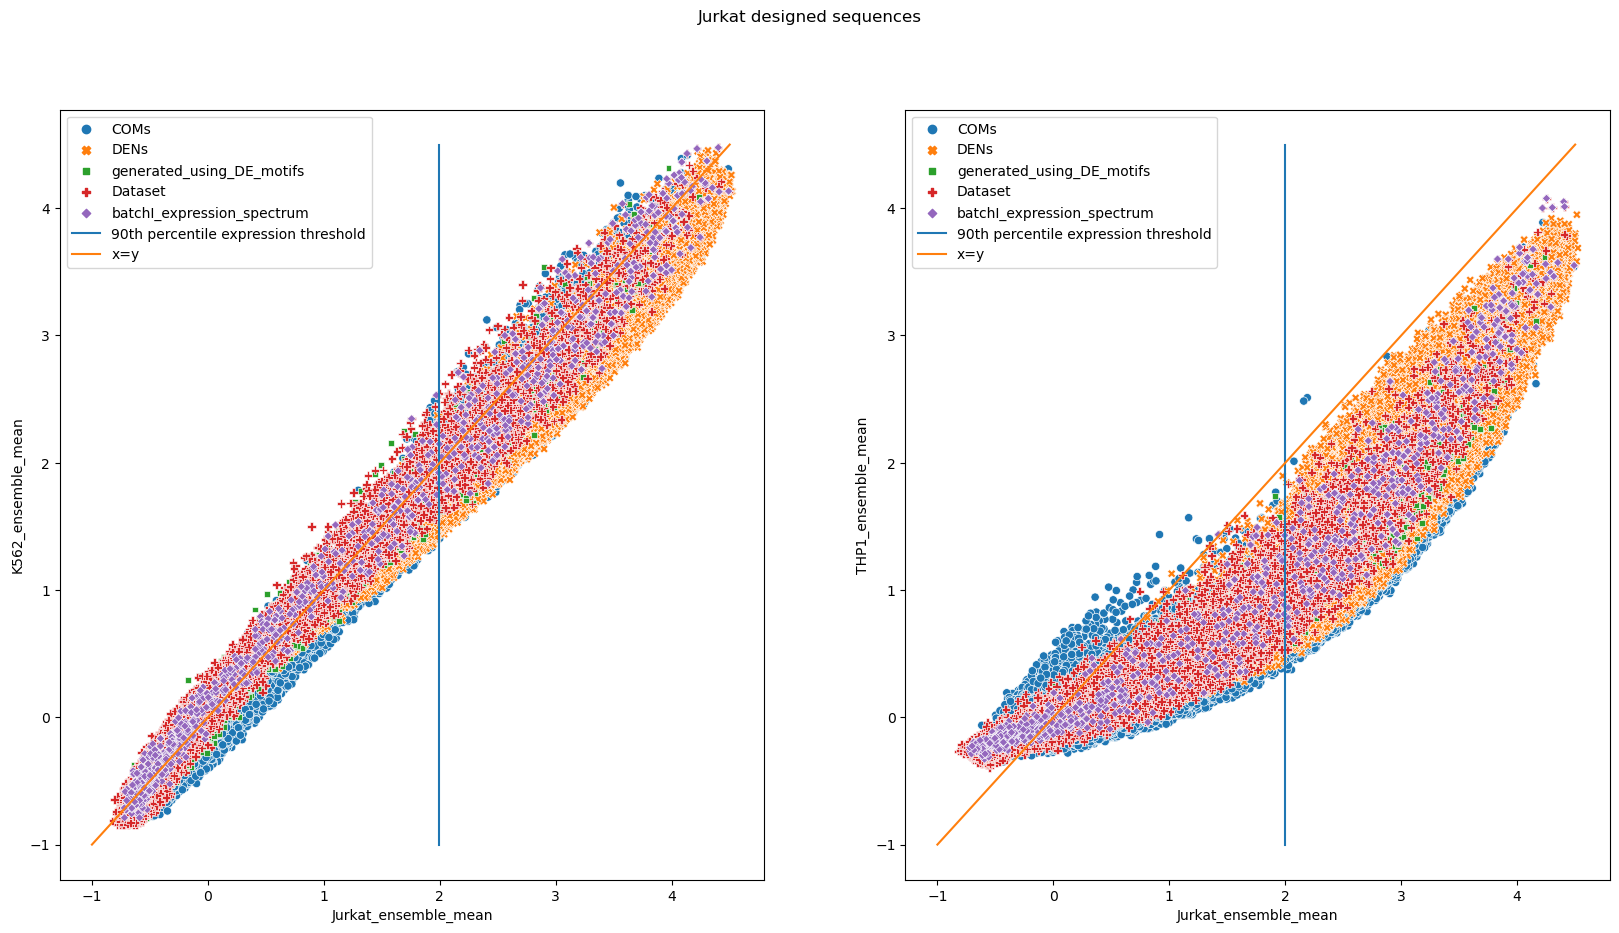

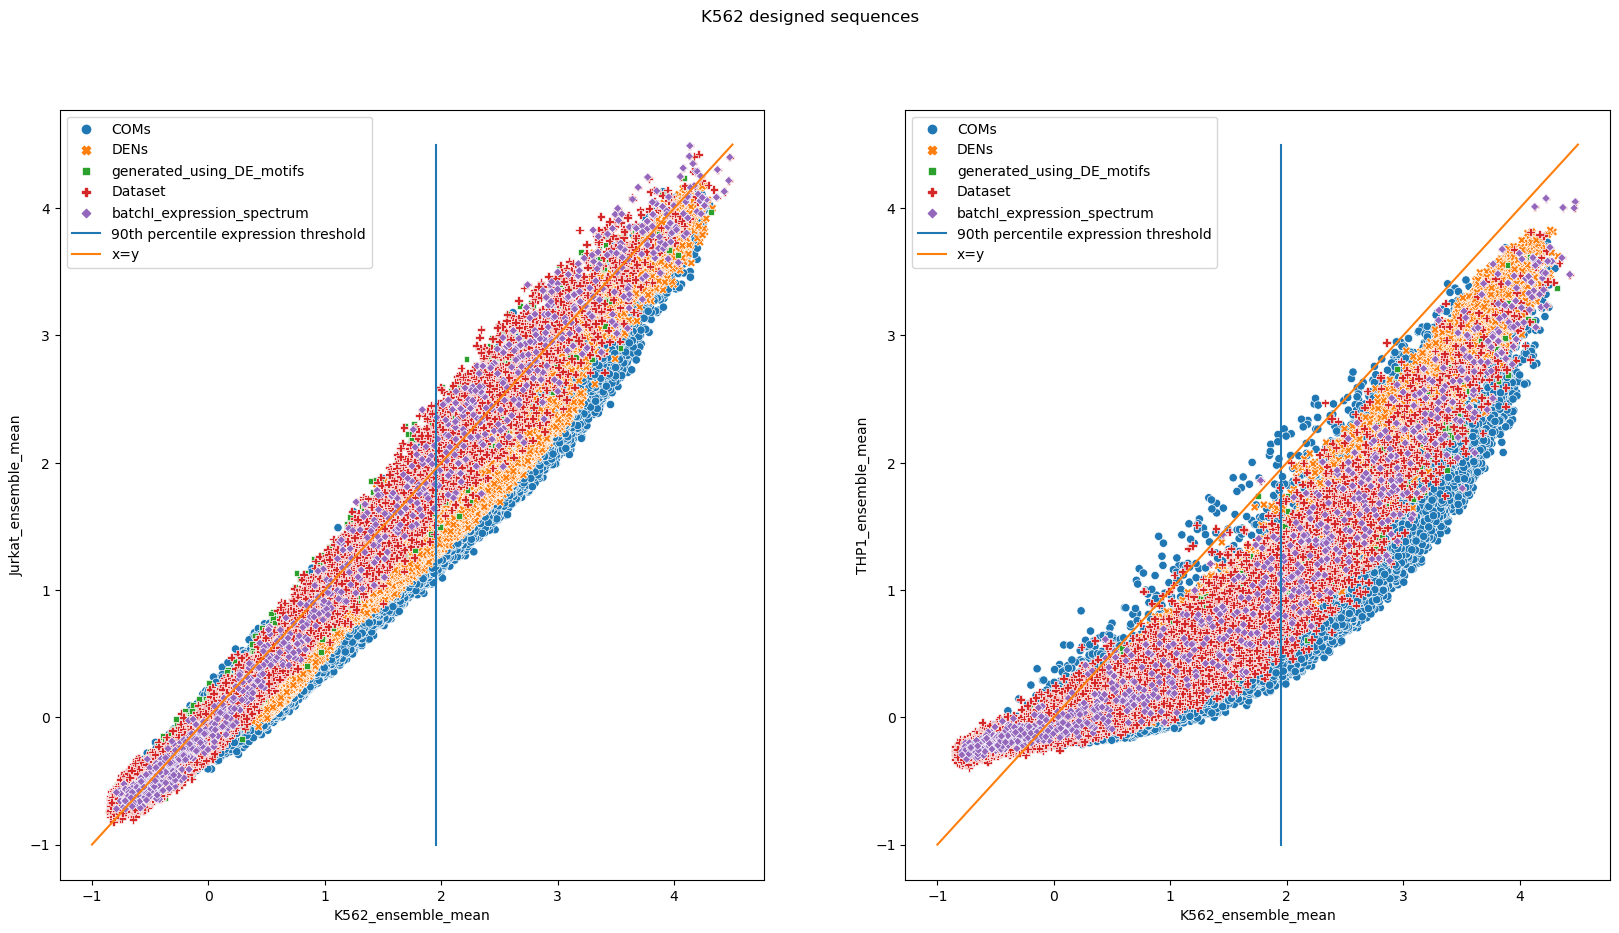

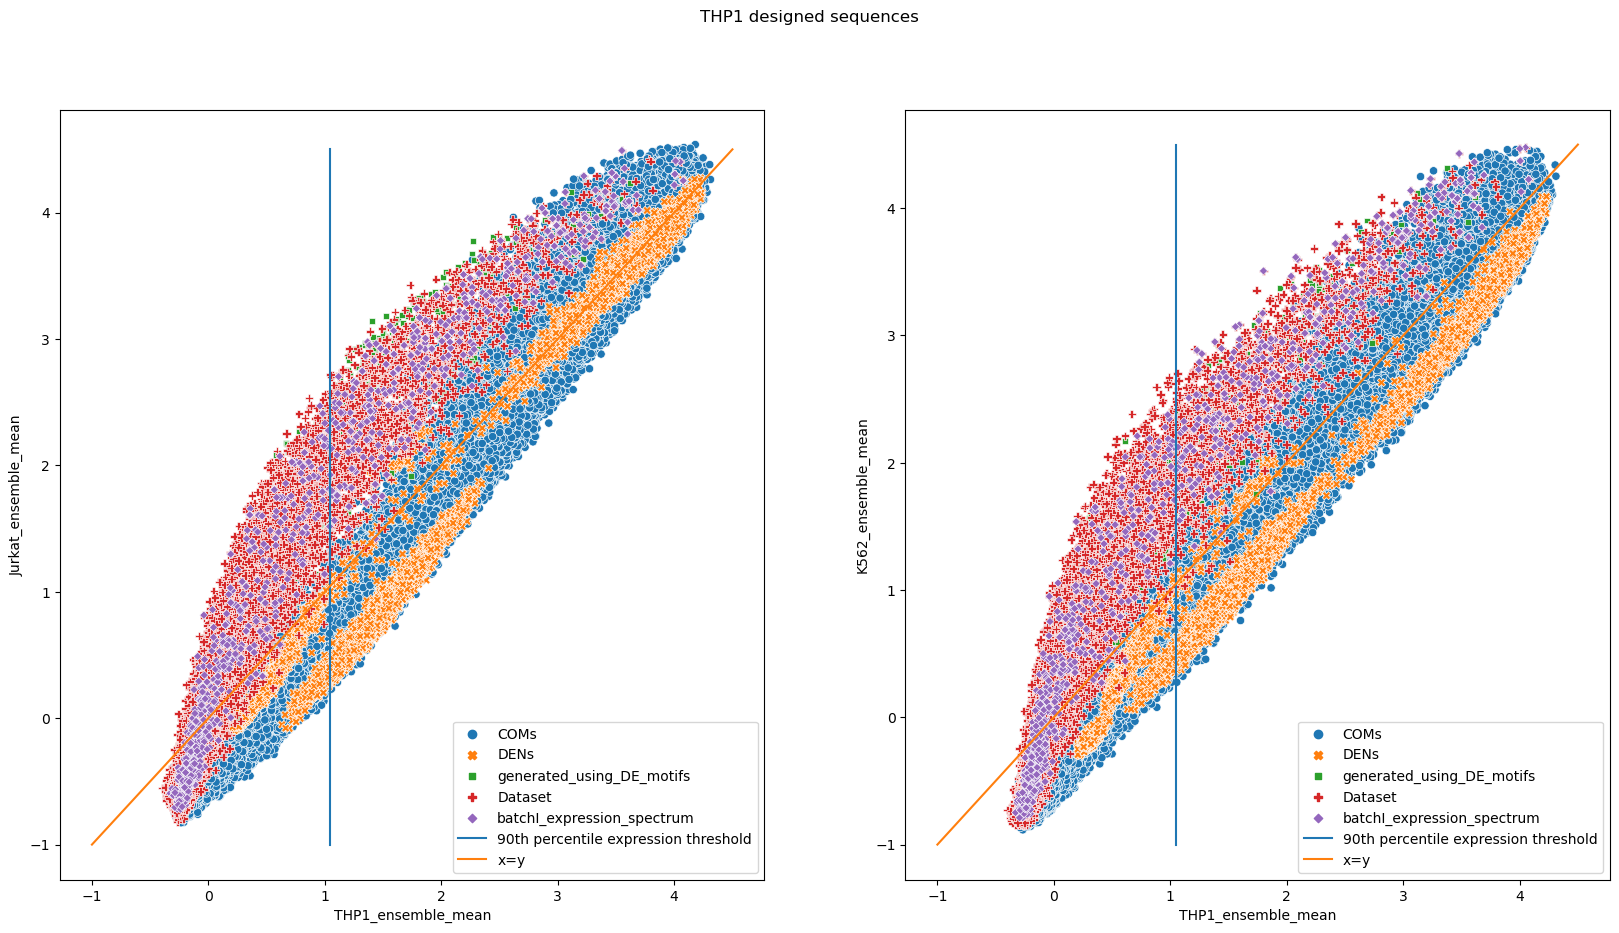

In [12]:
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    expression_percentile_thres_val = np.percentile(dataset_df[f"{cell1}_ensemble_mean"], expression_percentile_thres)
    
    subset_df = final_df[(final_df["designed_for"] == cell1) | (np.array(final_df["designed_for"]) == None)]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    c = 0
    for j, cell2 in enumerate(["Jurkat", "K562", "THP1"]):
        if i == j:
            continue
        
        sns.scatterplot(data=subset_df, 
                        x=f"{cell1}_ensemble_mean", 
                        y=f"{cell2}_ensemble_mean", 
                        hue="design_method", style="design_method",
                        hue_order=["COMs", 
                                   "DENs", 
                                   "generated_using_DE_motifs", 
                                   "Dataset",
                                   "batchI_expression_spectrum"],
                        ax=ax[c])
        ax[c].plot(np.zeros(5) + expression_percentile_thres_val, np.linspace(-1, 4.5, 5), 
                   label=f"{expression_percentile_thres}th percentile expression threshold")
        ax[c].plot(np.linspace(-1, 4.5), np.linspace(-1, 4.5), label="x=y")
        ax[c].legend()
        c += 1
        
    fig.suptitle(f"{cell1} designed sequences")
    plt.show()

In [13]:
# filter sequences based on predicted expression and sort by differential expression
coms_df["filter_out"] = False
dens_df["filter_out"] = False
coms_df["diff_exp"] = 0.0
dens_df["diff_exp"] = 0.0
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    print(cell1)
    expression_percentile_thres_val = np.percentile(dataset_df[f"{cell1}_ensemble_mean"], expression_percentile_thres)
    print(f"Expression threshold = {expression_percentile_thres_val}")
    
    ori_COMs_num_seqs = (coms_df['designed_for'] == cell1).sum()
    ori_DENs_num_seqs = (dens_df['designed_for'] == cell1).sum()
    print(f"We had {ori_COMs_num_seqs} COMs designed sequences")
    print(f"We had {ori_DENs_num_seqs} DENs designed sequences")
    
    coms_df.loc[(coms_df["designed_for"] == cell1) & 
                (coms_df[f"{cell1}_ensemble_mean"] < expression_percentile_thres_val), "filter_out"] = True
    dens_df.loc[(dens_df["designed_for"] == cell1) & 
                (dens_df[f"{cell1}_ensemble_mean"] < expression_percentile_thres_val), "filter_out"] = True
    
    COMs_left_after_exp_thres = ((coms_df['designed_for'] == cell1) & ~coms_df['filter_out']).sum()
    DENs_left_after_exp_thres = ((dens_df['designed_for'] == cell1) & ~dens_df['filter_out']).sum()
    print(f"After filtering based on the expression threshold, we have {COMs_left_after_exp_thres} COMs designed sequences")
    print(f"After filtering based on the expression threshold, we have {DENs_left_after_exp_thres} DENs designed sequences")
    
    coms_df.loc[coms_df["designed_for"] == cell1, 
                "diff_exp"] = coms_df.loc[coms_df["designed_for"] == cell1, 
                                          f"{cell1}_ensemble_mean"]
    dens_df.loc[dens_df["designed_for"] == cell1, 
                "diff_exp"] = dens_df.loc[dens_df["designed_for"] == cell1, 
                                          f"{cell1}_ensemble_mean"]
    for j, cell2 in enumerate(["Jurkat", "K562", "THP1"]):
        if cell1 == cell2:
            continue
        coms_df.loc[(coms_df["designed_for"] == cell1) & 
                    (coms_df[f"{cell1}_ensemble_mean"] < coms_df[f"{cell2}_ensemble_mean"]), "filter_out"] = True
        dens_df.loc[(dens_df["designed_for"] == cell1) & 
                    (dens_df[f"{cell1}_ensemble_mean"] < dens_df[f"{cell2}_ensemble_mean"]), "filter_out"] = True
        
        coms_df.loc[coms_df["designed_for"] == cell1, 
                "diff_exp"] -= (coms_df.loc[coms_df["designed_for"] == cell1, 
                                          f"{cell2}_ensemble_mean"] * 0.5)
        dens_df.loc[dens_df["designed_for"] == cell1, 
                "diff_exp"] -= (dens_df.loc[dens_df["designed_for"] == cell1, 
                                          f"{cell2}_ensemble_mean"] * 0.5)
        
    COMs_left_after_DE_filt = ((coms_df['designed_for'] == cell1) & ~coms_df['filter_out']).sum()
    DENs_left_after_DE_filt = ((dens_df['designed_for'] == cell1) & ~dens_df['filter_out']).sum()
    print(f"After filtering based on the having non-zero DE, we have {COMs_left_after_DE_filt} COMs designed sequences")
    print(f"After filtering based on the having non-zero DE, we have {DENs_left_after_DE_filt} DENs designed sequences")

Jurkat
Expression threshold = 1.993691277503968
We had 102144 COMs designed sequences
We had 69098 DENs designed sequences
After filtering based on the expression threshold, we have 44965 COMs designed sequences
After filtering based on the expression threshold, we have 51179 DENs designed sequences
After filtering based on the having non-zero DE, we have 44079 COMs designed sequences
After filtering based on the having non-zero DE, we have 49625 DENs designed sequences
K562
Expression threshold = 1.9541875004768374
We had 102144 COMs designed sequences
We had 38668 DENs designed sequences
After filtering based on the expression threshold, we have 50434 COMs designed sequences
After filtering based on the expression threshold, we have 8436 DENs designed sequences
After filtering based on the having non-zero DE, we have 49399 COMs designed sequences
After filtering based on the having non-zero DE, we have 7865 DENs designed sequences
THP1
Expression threshold = 1.0461508750915527
We had

In [14]:
coms_df = coms_df[~coms_df["filter_out"]].sort_values(by="diff_exp").reset_index(drop=True)
dens_df = dens_df[~dens_df["filter_out"]].sort_values(by="diff_exp").reset_index(drop=True)
coms_df.to_parquet(os.path.join(ensemble_predictions_dir, "filtered_coms_sequences_ensemble_4.parquet"))
dens_df.to_parquet(os.path.join(ensemble_predictions_dir, "filtered_dens_sequences_ensemble_4.parquet"))

Jurkat


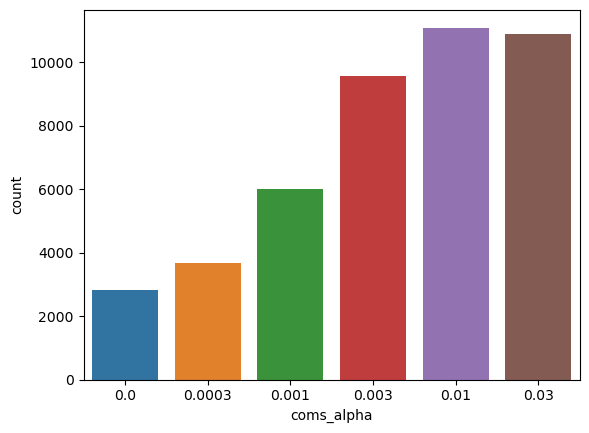

K562


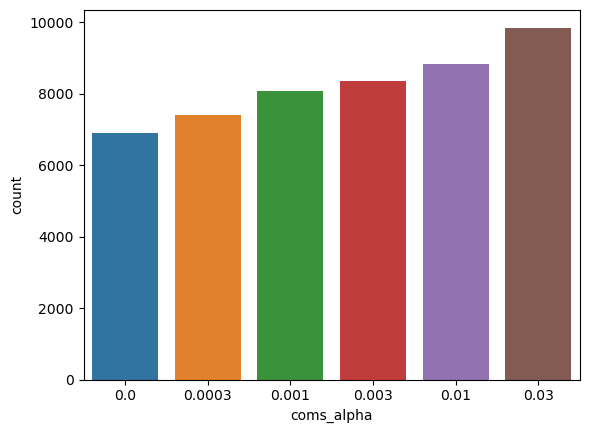

THP1


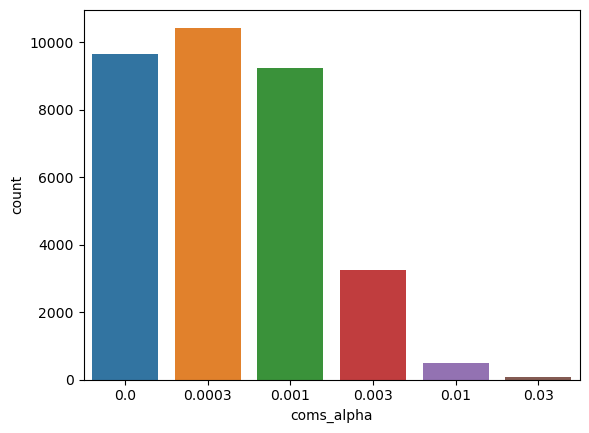

In [15]:
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    print(cell1)
    sns.countplot(data=coms_df[coms_df["designed_for"] == cell1], x="coms_alpha")
    plt.show()

In [16]:
final_df = pd.concat([coms_df, 
                      dens_df, 
                      sequences_generated_using_DE_motifs_df,
                      dataset_df,
                      sequences_from_batch_1_expression_spectrum_df]).reset_index(drop=True)
final_df.to_parquet(os.path.join(ensemble_predictions_dir, "filtered_ensemble_4_predictions.parquet"))
final_df

design_method designed_for  \
0                             COMs         THP1   
1                             COMs         THP1   
2                             COMs         THP1   
3                             COMs         THP1   
4                             COMs         THP1   
...                            ...          ...   
209917  batchI_expression_spectrum         None   
209918  batchI_expression_spectrum         None   
209919  batchI_expression_spectrum         None   
209920  batchI_expression_spectrum         None   
209921  batchI_expression_spectrum         None   

                                        original_sequence  \
0       GTGACGGGGCTCCACTGTGTCGGGGACACCTACCCCAGCAACGACC...   
1       TTGCTGAGGACACCCAGAAGAATGTGATCTCCGCGCGGGTGCCTGA...   
2       ACAGCATCACTACACTTAAAAATTTCCCTCCTCACCCCCAGATTCC...   
3       GCATTGGCCAGATATGTCGTCACTCACAAAACTTCGAGCTCATTGG...   
4       TGCCTGGCATACAGTAGGTAATTAATGGAGTATTTGATGAGCGCAT...   
...                                                   ...   
209917                                               None   
209918                                               None   
209919                                               None   
209920                                               None   
209921                                               None   

                                                 sequence provenance  \
0       CCGCCCGTCCGCCGCGCCGGCCGCCGGGCGCCTTCCAAGAACTACC...       None   
1       ACCTCCAGGGTTTGAGGGGAAATTGTCTCTCCGCGCTGCCCTCCGC...       None   
2       GAAGCCGCGCGACGAAACGCCAGTCTCTTCCGCCTTCGTAGAAGCC...       None   
3       GCTCGAGGCAGTGCTCTCGTCGGCTGCAGAAACGGAAGCTGAGCCA...       None   
4       TTCCTGGAACAGAGCAGCAGTGCCGTGGAGAGGACGAAGGGATCAA...       None   
...                                                   ...        ...   
209917  AGCTTTATAGGAATGCTGTTGCTTTAAATCCGAAATCCCGTGCCGG...       None   
209918  AAACTCAGCGTGGGGTGGTGGGTTTCCCCGTCTTCTGGGAGACCCG...       None   
209919  GCGCGGGGCCAATCAGCGTGCGCCGTTCCGAAAGTTGCCTTTTATG...       None   
209920  GTGCGTCGGCTTCCGTACAACACGGATACTCTCTCTCTGACGCAAC...       None   
209921  GCAAGTGGGCAGTGAGTGTGCCACGGACTGGCCTGGGCTGTGGCCT...       None   

        coms_alpha diversity_loss_coef entropy_loss_coef  \
0           0.0010                None              None   
1           0.0030                None              None   
2           0.0100                None              None   
3           0.0030                None              None   
4           0.0003                None              None   
...            ...                 ...               ...   
209917         NaN                None              None   
209918         NaN                None              None   
209919         NaN                None              None   
209920         NaN                None              None   
209921         NaN                None              None   

       base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_measured  \
0                        None              3.960525  ...           None   
1                        None              4.084723  ...           None   
2                        None              3.103304  ...           None   
3                        None              2.477976  ...           None   
4                        None              3.897619  ...           None   
...                       ...                   ...  ...            ...   
209917                   None              4.252730  ...       5.882017   
209918                   None             -0.360493  ...       5.780755   
209919                   None              2.427932  ...        5.68394   
209920                   None              3.830371  ...       4.775424   
209921                   None             -0.504501  ...        6.17558   

        THP1_ensemble_mean THP1_ensemble_std  THP1_design_model  \
0                 3.961377          0.568612           3.465319   
1                 4.085656          0.597134          

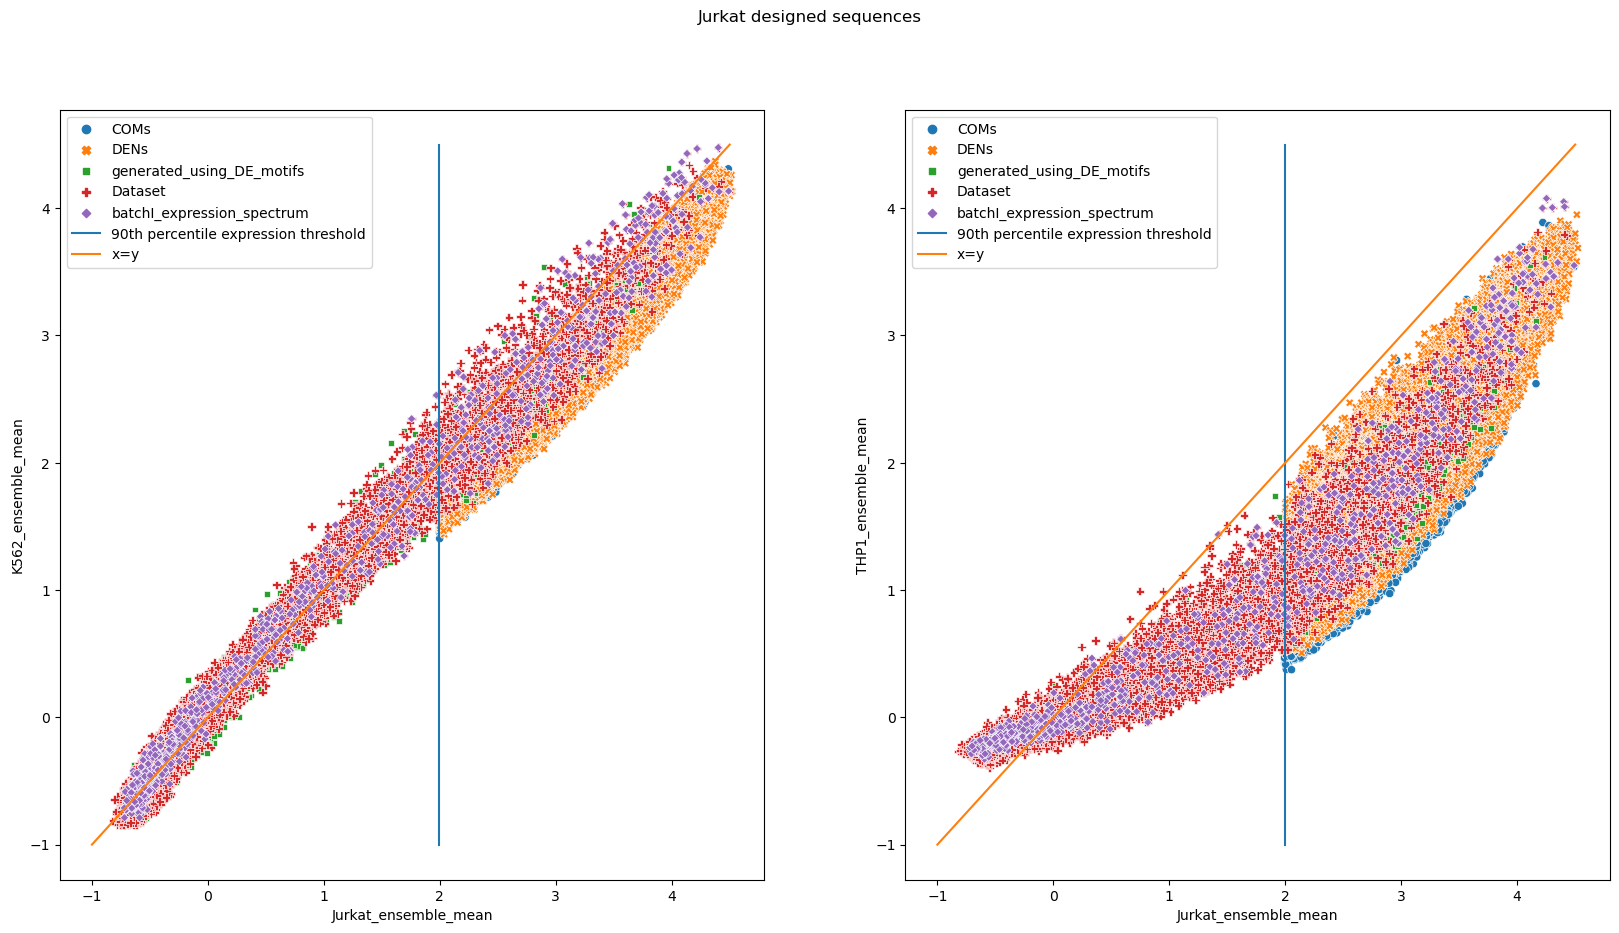

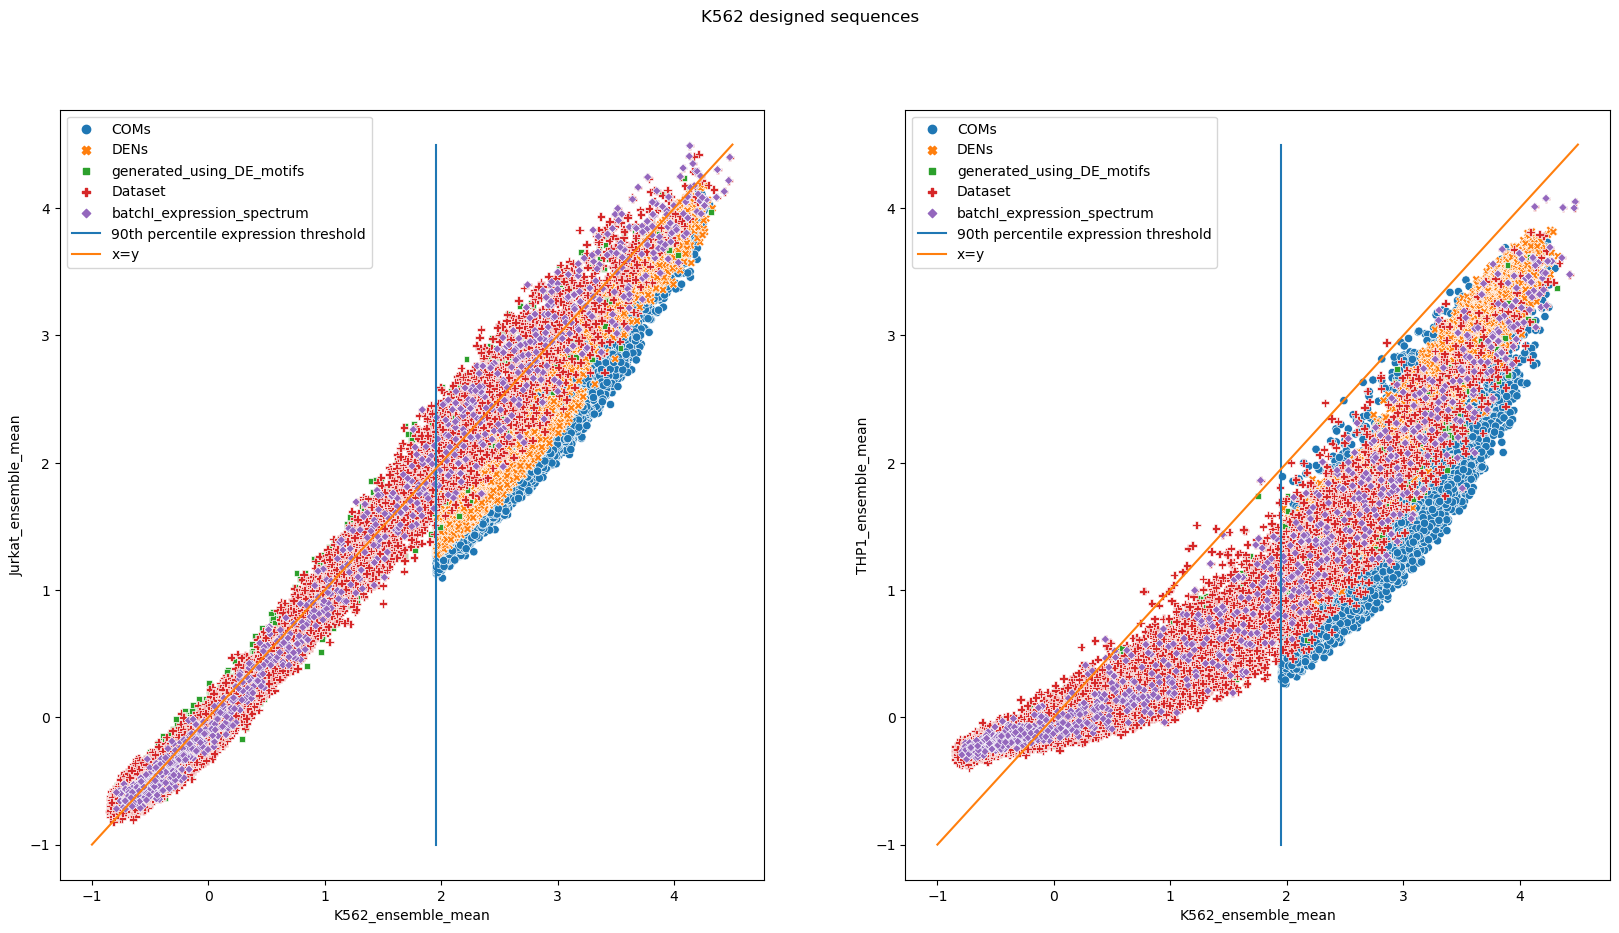

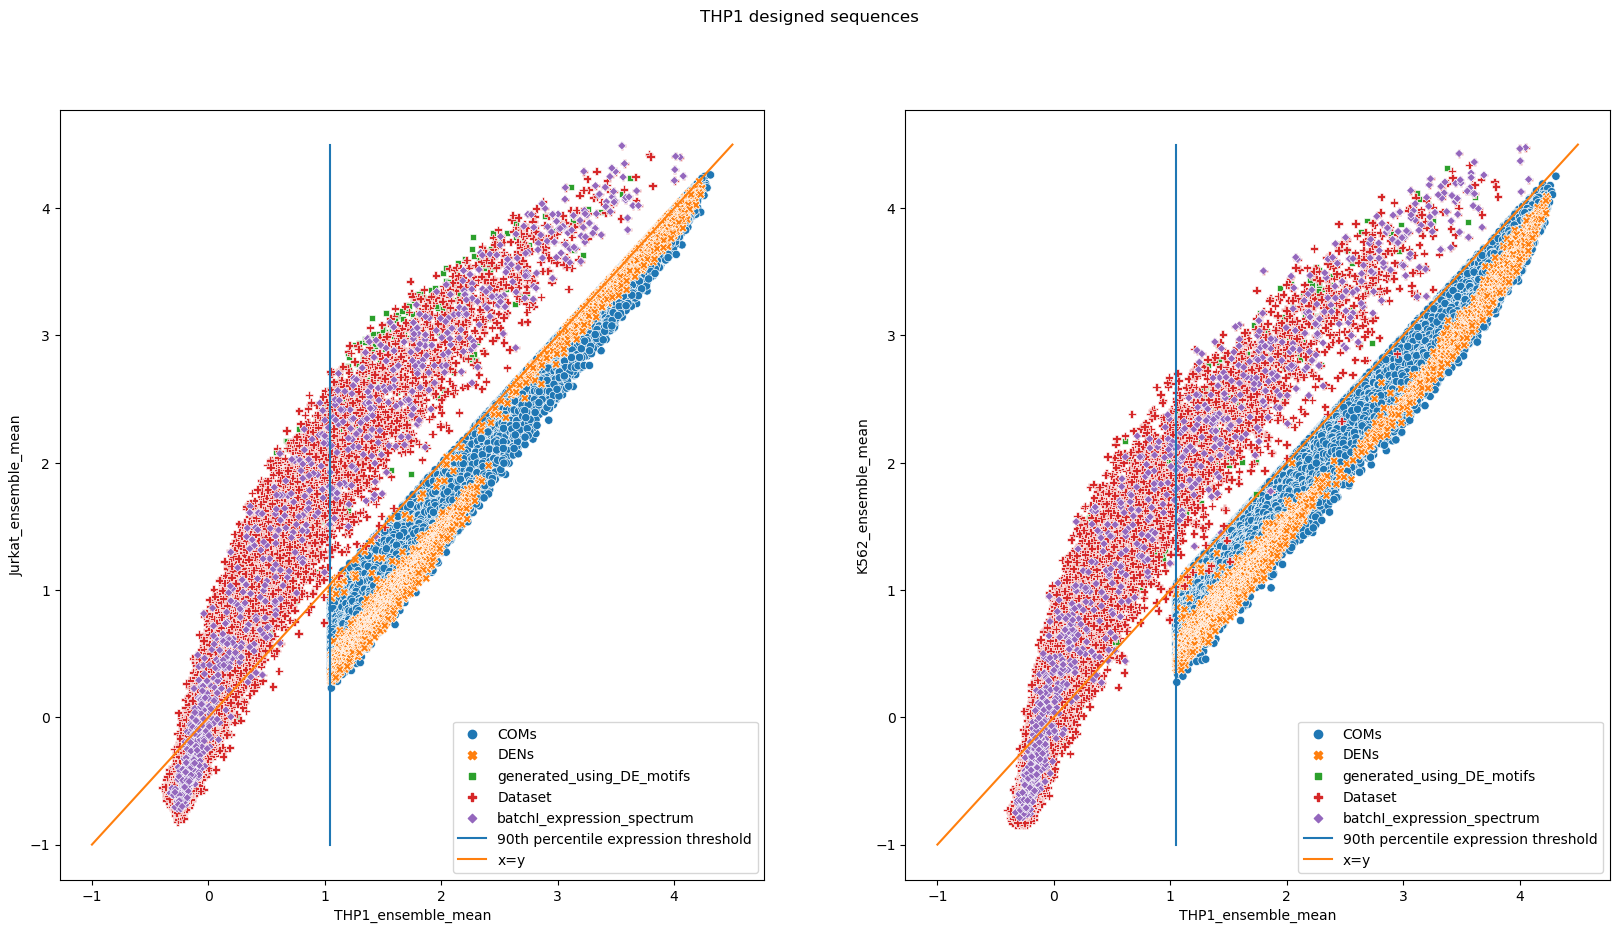

In [17]:
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    expression_percentile_thres_val = np.percentile(dataset_df[f"{cell1}_ensemble_mean"], expression_percentile_thres)
    
    subset_df = final_df[(final_df["designed_for"] == cell1) | (np.array(final_df["designed_for"]) == None)]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    c = 0
    for j, cell2 in enumerate(["Jurkat", "K562", "THP1"]):
        if i == j:
            continue
        
        sns.scatterplot(data=subset_df, 
                        x=f"{cell1}_ensemble_mean", 
                        y=f"{cell2}_ensemble_mean", 
                        hue="design_method", style="design_method",
                        hue_order=["COMs", 
                                   "DENs", 
                                   "generated_using_DE_motifs", 
                                   "Dataset",
                                   "batchI_expression_spectrum"],
                        ax=ax[c])
        ax[c].plot(np.zeros(5) + expression_percentile_thres_val, np.linspace(-1, 4.5, 5), 
                   label=f"{expression_percentile_thres}th percentile expression threshold")
        ax[c].plot(np.linspace(-1, 4.5), np.linspace(-1, 4.5), label="x=y")
        ax[c].legend()
        c += 1
        
    fig.suptitle(f"{cell1} designed sequences")
    plt.show()

In [18]:
coms_df[["designed_for", "sequence", "Jurkat_ensemble_mean", "K562_ensemble_mean", "THP1_ensemble_mean", "diff_exp"]].sort_values(by="diff_exp", ascending=False)

designed_for                                           sequence  \
126602         K562  AAGAGGGCCCGCCGCCCAGCGGCACTCAGCTGATAGGTCCAAATGG...   
126601         K562  ATTCAGGTCCAACGTTTAAAAAAAAAAAATCAACCAATCAAACCAC...   
126600         K562  GTTCAGACGGCCGGCCAACGATTGATAGCATCAGTGCCCAAAGTCC...   
126599         K562  ACGCTAAGCATCCAAAGGCCAGTAGCTAACATCCCTCAGCTAATAA...   
126598         K562  TATACTTGGAGGCCAAGCCACTCTAACCTCGGCACCCTCCAGTAAA...   
...             ...                                                ...   
4              THP1  TTCCTGGAACAGAGCAGCAGTGCCGTGGAGAGGACGAAGGGATCAA...   
3              THP1  GCTCGAGGCAGTGCTCTCGTCGGCTGCAGAAACGGAAGCTGAGCCA...   
2              THP1  GAAGCCGCGCGACGAAACGCCAGTCTCTTCCGCCTTCGTAGAAGCC...   
1              THP1  ACCTCCAGGGTTTGAGGGGAAATTGTCTCTCCGCGCTGCCCTCCGC...   
0              THP1  CCGCCCGTCCGCCGCGCCGGCCGCCGGGCGCCTTCCAAGAACTACC...   

        Jurkat_ensemble_mean  K562_ensemble_mean  THP1_ensemble_mean  diff_exp  
126602              2.103949            2.913470            1.096087  1.313452  
126601              2.071550            2.939931            1.183631  1.312341  
126600              2.342810            3.122211            1.285997  1.307808  
126599              2.013448            2.889232            1.154022  1.305497  
126598              1.998005            2.950232            1.292194  1.305133  
...                      ...                 ...                 ...       ...  
4                   3.897619            3.896999            3.902343  0.005034  
3                   2.477976            2.483916            2.485921  0.004975  
2                   3.103304            3.093574            3.103351  0.004912  
1                   4.084723            4.078242            4.085656  0.004174  
0                   3.960525            3.959001            3.961377  0.001614  

[126603 rows x 6 columns]

In [19]:
dens_df[["designed_for", "sequence", "Jurkat_ensemble_mean", "K562_ensemble_mean", "THP1_ensemble_mean", "diff_exp"]].sort_values(by="diff_exp", ascending=False)

designed_for                                           sequence  \
63711       Jurkat  CGCCCGCCGCATCGCGCGTCGCCCGCGCGATTACGCGTGGGGGCGT...   
63710       Jurkat  CGCGTCTCGCGAGTGCGGCGGCGTCGCGCGGCGCGCGCGGCGTCGC...   
63709       Jurkat  CCCCGCGCGTCGGGGGCGCGCGAGCGCTCGCGCGGCGCCCGCGGCG...   
63708       Jurkat  GTGTAGTGGAGGGATAAGCGCATAACATCGCGGCGTCGCGTCGCGT...   
63707       Jurkat  GCGAGTGTTCTCGCGAGTGGCGCGCGCGCGCGCGCGCGCGCGGCGC...   
...            ...                                                ...   
4             THP1  CCGGAACCAGGAAGCGGAAGCTGGAAGCCGGAAAACGAGGAAGAAG...   
3             THP1  GACGCGACGCGACACAACGACGCGCGACGCGGCGGCGGCCGCCCGC...   
2             THP1  GCGACGCACGCGACGACGCCCGACGACGCGGAAGACGAACGACGAC...   
1             THP1  ACGACGGACGAAGAAGACGGACGACACGAAGGCATTGCGACGGCCG...   
0             THP1  CGCGACGACGACGCGACGACGACGACGACACGCGACGCGACGCCGC...   

       Jurkat_ensemble_mean  K562_ensemble_mean  THP1_ensemble_mean  diff_exp  
63711              3.270927            2.612840            1.508151  1.210431  
63710              3.366953            2.721103            1.599391  1.206706  
63709              3.383973            2.660218            1.706055  1.200836  
63708              3.599133            2.948314            1.850352  1.199799  
63707              3.440755            2.708047            1.781010  1.196226  
...                     ...                 ...                 ...       ...  
4                  2.045264            1.996995            2.045927  0.024798  
3                  1.076217            1.092656            1.108388  0.023951  
2                  1.115089            1.153044            1.153411  0.019345  
1                  1.097248            1.072081            1.103710  0.019045  
0                  1.081564            1.068362            1.083776  0.008813  

[63712 rows x 6 columns]

In [20]:
all_ensemble_1_predictions = pd.read_parquet(os.path.join(ensemble_predictions_dir, "all_ensemble_1_predictions.parquet"))
all_ensemble_4_predictions = pd.read_parquet(os.path.join(ensemble_predictions_dir, "all_ensemble_4_predictions.parquet"))

In [22]:
for cell in ["Jurkat", "K562", "THP1"]:
    print(cell, stats.spearmanr(all_ensemble_1_predictions[f"{cell}_ensemble_mean"], 
                                all_ensemble_4_predictions[f"{cell}_ensemble_mean"]))

Jurkat SignificanceResult(statistic=0.9643398591154432, pvalue=0.0)
K562 SignificanceResult(statistic=0.9403538333541206, pvalue=0.0)
THP1 SignificanceResult(statistic=0.9497066817857334, pvalue=0.0)


In [23]:
filtered_ensemble_1_predictions = pd.read_parquet(os.path.join(ensemble_predictions_dir, "filtered_ensemble_1_predictions.parquet"))
filtered_ensemble_4_predictions = pd.read_parquet(os.path.join(ensemble_predictions_dir, "filtered_ensemble_4_predictions.parquet"))

In [26]:
s1 = set(filtered_ensemble_1_predictions[(filtered_ensemble_1_predictions["design_method"] == "COMs") | 
                                (filtered_ensemble_1_predictions["design_method"] == "DENs")]["sequence"])
s4 = set(filtered_ensemble_4_predictions[(filtered_ensemble_4_predictions["design_method"] == "COMs") | 
                                (filtered_ensemble_4_predictions["design_method"] == "DENs")]["sequence"])

In [27]:
print(len(s1), len(s4), len(s1.intersection(s4)))

231994 190315 179987
